<h1 align="center">KDD Cup 1999 Classification Model</h1>

In this Jupyter Notebook project, modern machine learning libraries are applied onto an older dataset - the [KDD Cup 1999](https://www.kdd.org/kdd-cup/view/kdd-cup-1999/Data) dataset. The dataset is a simulation of a military computer network; the records are comprised of internet connections that are classified as either normal connections or detected intrusion (with a specified attack type). A supervised machine learning model is built to perform binary classifications on whether a record is normal or an intrusion. The motivations of this project were to investigate the effectiveness of machine learning algorithms on a dataset that historically was much harder to build a model for.

<hr style="border-top: 2px solid #444">

## Development Environment
In this section, the development environment for this Jupyter notebook project is prepared by collecting Python dependencies, importing libraries, and configuring the runtime environment.

### Python Dependencies
External Python dependencies are collected through the [Pipenv](https://pypi.org/project/pipenv/) package manager since it supports dependency lock-files. In the following script, `pipenv` and its transitive dependencies are installed from `pipenv-requirements.txt` and then the notebook's dependencies are installed from `Pipfile` and `Pipfile.lock`.

In [1]:
!pip install -r pipenv-requirements.txt
!pipenv install

### Library Imports
All internal standard libraries and external libraries are imported here, with some stated dependency versions.

In [2]:
import gzip
import math
import os
import re
import sys
from enum import Enum
from io import StringIO
from time import time

import matplotlib.pyplot as pyplot
import numpy
import pandas
import requests
import tensorflow
from IPython.display import display, HTML
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

### Configure PRNG Seed
Numpy, Tensorflow, and SciKit rely on [pseudorandom number generators](https://en.wikipedia.org/wiki/Pseudorandom_number_generator) as their internal source for randomness. To guarantee deterministic behaviour and reproducible results for this notebook's execution, an arbitrary seed is configured.

In [3]:
PRNG_SEED = 42

numpy.random.seed(PRNG_SEED)
tensorflow.random.set_seed(PRNG_SEED)

<hr style="border-top: 2px solid #444">

## I. Data Importation

In this section, the dataset and its attributes are fetched from a remote web server, cached to disk, and loaded into memory as a Pandas DataFrame.

The dataset files are available here: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

In [4]:
# create 'data' cache directory
if not os.path.exists('data'):
    os.path.makedirs('data')

### Fetch Column Types: Categorical vs Continuous
There are 42 distinct columns within the dataset's manifest, which is fetched below. Columns may define categorical data that needs to be encoded or continuous values that need to be normalized.

In [5]:
DATASET_COLUMNS_FILE = os.path.join("data", "kddcup1999_columns.txt")

if not os.path.exists(DATASET_COLUMNS_FILE):
    with requests.get("http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names") as request:
        with open(DATASET_COLUMNS_FILE, 'wb') as file:
            file.write(request.content)

### Parse Column Types
The dataset's manifest on columns is loaded from the file cache, parsed, and loaded into memory as a dict.

In [6]:
ColumnType = Enum('ColumnType', 'SYMBOLIC CONTINUOUS')
column_types = {}

with open(DATASET_COLUMNS_FILE, 'r') as file:
    column_labels: str = file.read()

column_regex: re.Pattern = re.compile(r"^(?P<column_name>\w+): (?P<data_type>\w+)\.$")
for column_type in column_labels.splitlines()[1:]:
    match = column_regex.match(column_type)
    column_types[match.group("column_name")] = ColumnType[match.group("data_type").upper()]

### Fetch Labeled CSV Dataset
In this subsection, the 743 MiB KDD Cup 1999 dataset is fetched, GZIP decompressed, and cached to file.

In [7]:
DATASET_URL = "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz"
DATASET_FILE = os.path.join("data", "kddcup1999.csv")

# download dataset if not already cached
if not os.path.exists(DATASET_FILE):
    with requests.get(DATASET_URL) as response:
        if response.status_code != 200:
            raise RuntimeError(f"failed to download dataset: {DATASET_URL}")
        # decompress content
        with open(DATASET_FILE, 'wb') as file:
            file.write(gzip.decompress(response.content))

### Load CSV Dataset

In this subsection, the CSV dataset is loaded from its file cache into memory as a Pandas DataFrame. A few records of the dataset are shown as an example below.

In [8]:
dataframe = pandas.read_csv(
    # file to import from
    DATASET_FILE,
    # important to specify the CSV file contains no headers
    # otherwise, the first record is interpreted as a header
    header=None,
)
dataframe.columns = [*column_types.keys(), "outcome"]

pandas.set_option('display.max_rows', 10)
dataframe

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,tcp,http,SF,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal.
4898427,0,tcp,http,SF,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal.
4898428,0,tcp,http,SF,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal.
4898429,0,tcp,http,SF,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal.


<hr style="border-top: 2px solid #444">

## II. Inspecting Dataset

Prior to creating the machine learning model, the nature of the dataset needs to be investigated. In this section, some quick explorations are done on the count of normal connections versus intrusion detections.

### Normal Connections vs Intrusion Detections

The frequency of normal connections is compared to the frequency of detected intrusions. The dataset is fairly imbalanced and will require some balancing techniques to prevent overtraining the intrusion classification.

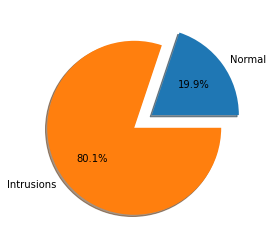

In [9]:
type_frequencies = dataframe['outcome'].value_counts()
normal_frequency = type_frequencies['normal.']
intrusion_frequency = sum([count for outcome_type, count in type_frequencies.iteritems() if outcome_type != 'normal.'])

figure = pyplot.figure()
pyplot.pie(
    [normal_frequency, intrusion_frequency],
    labels=["Normal", "Intrusions"],
    explode=[0, .25],
    autopct='%1.1f%%',
    shadow=True,
)
pyplot.show()

### Intrusion Frequency
The frequency of each type of detected intrusion is computed below. Unfortunately, the intrusions are also highly imbalanced - several types are on completely different orders of magnitudes. Less detected intrusions will have poorer performance in model training. The frequency count cannot be visualized well, barring the use of a logarithmic y-axis, which does not well encapsulate the skewness.

In [10]:
intrusion_frequencies=type_frequencies.drop(labels=["normal."])

pandas.set_option('display.max_rows', None)
display(
    pandas.DataFrame(
        intrusion_frequencies.values,
        columns=['frequency'],
        index=[intrusion_name[:-1] for intrusion_name in intrusion_frequencies.index]
    ).sort_values(by="frequency", ascending=False)
)
pandas.set_option('display.max_rows', 10)

,frequency
smurf,2807886
neptune,1072017
satan,15892
ipsweep,12481
portsweep,10413
nmap,2316
back,2203
warezclient,1020
teardrop,979
pod,264


<hr style="border-top: 2px solid #444">

## III. Data Preprocessing

In this section, the CSV dataset is preprocessed into strictly numerical data for the machine learning model. The dataset is transformed by dropping duplicate records, partionining into several datasets (training, testing, validation) one-hot-encoding categorical data, and normalizing continuous values based on the distribution in the training dataset.

### Drop Duplicate Records

In the following code, all duplicate records are dropped from the dataset to prevent bias and over-training.

In [11]:
unique_dataframe = dataframe.drop_duplicates()

print(f"Dropped {len(dataframe) - len(unique_dataframe):,}/{len(dataframe):,} (-{100*(len(dataframe) - len(unique_dataframe))/len(dataframe):.2f}%) duplicate records")

Dropped 3,823,439/4,898,431 (-78.05%) duplicate records


### One-hot-encode Categorical ("Symbolic") Columns

Several columns within the dataset describe categorical data, and have no useful numerical representation. To represent this data numerically, the columns are [one-hot-encoded](https://en.wikipedia.org/wiki/One-hot). This encoding is done prior to dataset partitioning, as all partitions need to be consistent with their columns.

In [12]:
encoded_dataframe = pandas.get_dummies(
    unique_dataframe,
    # all categorical columns
    columns=[column_name for column_name, column_type in column_types.items() if column_type == ColumnType.SYMBOLIC],
    # drop original column
    drop_first=True,
)

pandas.set_option('display.max_rows', 10)
encoded_dataframe

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,land_1,logged_in_1,is_host_login_1,is_guest_login_1
0,0,215,45076,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
1,0,162,4528,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,0,236,1228,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,0,233,2032,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4,0,239,486,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,212,2288,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4898427,0,219,236,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4898428,0,218,3610,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
4898429,0,219,1234,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0


### Dataset Partitioning: Training, Testing, and Validation

The testing data in the dataset is unlabeled and cannot be used to measure the performance of the machine learning model. The main training dataset is partitioned in this notebook for 3 different uses:
- **training**: used for training the model
- **validation**: provides an evaluation of the model fit during training
- **testing**: provides an evaluation of the final fitted model

For the training partition, the dataset is resampled to equally represent normal and intrusion classifications. Furthermore, the 50% of intrusion records in the dataset are equally resampled into each of the 22 intrusion classification types. This resampling is designed to prevent bias for any particular type of record.

In [13]:
TRAINING_PROPORTION = .25
TESTING_PROPORTION = .70
VALIDATION_PROPORTION = .05

assert TRAINING_PROPORTION + TESTING_PROPORTION + VALIDATION_PROPORTION <= 1.0

partitions = {'train': pandas.DataFrame()}

remaining_dataframe = pandas.DataFrame()
grouped_outcomes = encoded_dataframe.groupby('outcome')
maximum_per_class = math.ceil((TRAINING_PROPORTION * len(grouped_outcomes.groups['normal.'])) / (len(grouped_outcomes.groups.keys()) - 1))
for key in grouped_outcomes.groups.keys():
    group = grouped_outcomes.get_group(key)

    training, remaining = train_test_split(
        group,
        shuffle=True,
        train_size=min(math.ceil(TRAINING_PROPORTION * len(group.index)), maximum_per_class) if key != "normal." else TRAINING_PROPORTION,
    )
    if key != "normal.":
        training = training.sample(n=maximum_per_class, replace=True, random_state=PRNG_SEED)
    partitions['train'] = partitions['train'].append(training)
    remaining_dataframe = remaining_dataframe.append(remaining)

partitions['test'], partitions['validate'] = train_test_split(
    remaining_dataframe,
    shuffle=True,
    train_size=TESTING_PROPORTION / (1 - TRAINING_PROPORTION),
    test_size=VALIDATION_PROPORTION / (1 - TRAINING_PROPORTION),
)

### Normalize Continuous Columns

The majority of columns describe continuous data that needs to be normalized to be meaningfully used by the trained model. Partitioning is done prior, as the testing and validation datasets should be normalized based on the distribution of the training data, not the entire dataset. The columns are normalized in-place using z-score normalization.

In [14]:
pandas.set_option("mode.chained_assignment", None)

for column_name, column_type in column_types.items():
    if column_type == ColumnType.CONTINUOUS:
        mean = partitions['train'][column_name].mean()
        std = partitions['train'][column_name].std()
        if std == 0:
            std = 1

        for partition_name, dataframe in partitions.items():
            dataframe.loc[:,column_name] = (dataframe[column_name] - mean) / std

### Input Features

The input features for each partition are collected here by creating a new dataframe without the `outcome` column.

In [15]:
tf_input = {
    partition_name: dataframe.drop("outcome", axis="columns").reset_index(drop=True)
    for partition_name, dataframe in partitions.items()
}

### Output Features

The output features for each partition are collected here by selecting the `outcome` column and one-hot-encoding it as a binary classification - either a normal connection or detected intrusion.

In [16]:
tf_output = {
    partition_name: pandas.DataFrame(
        # one-hot-encode normal vs intrusions for binary classification
        [
            [1, 0] if outcome == 'normal.' else [0, 1]
            for outcome in dataframe[['outcome']].to_numpy()
        ],
        # binary classification of connection
        columns=['normal', 'intrusion'],
    )
    for partition_name, dataframe in partitions.items()
}

<hr style="border-top: 2px solid #444">

## IV. Intrusion Detection - Binary Classification Model
Using the defined input and output feature matrices, a neural network can be trained with a binary classification model.

### Create Model
A supervised learning Sequential neural network is constructed for building a binary classification model. A simple model with fully-connected dense layers is employed here, with a softmax last layer.

In [17]:
# build model
model = Sequential(
    [
        Dense(128, input_dim=tf_input['train'].shape[1]),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(tf_output['train'].shape[1], activation='softmax')
    ],
    name="kdd_cup_1999_classification"
)
# set optimizer settings
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# print model summary
model.summary()

Model: "kdd_cup_1999_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               15360     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 34        
Total params: 26,258
Trainable params: 26,258
Non-trainable params: 0
_________________________________________________________________


### Train Model
The training and validation dataset partitions are fed into the supervised learning model. The best model is saved for later testing to determine model performance.

In [18]:
start_time = time()

# store standard out stream
original_stdout = sys.stdout
# replace standard out for intercepting model training logs
sys.stdout = captured_stdout = StringIO()

try:
    # make temporary directory for saved model
    if not os.path.exists("temp"):
        os.mkdir("temp")

    # perform model training
    model.fit(
        # training data
        tf_input['train'], tf_output['train'],
        # use test data to validate losses, but not for training
        validation_data=(tf_input['validate'], tf_output['validate']),
        callbacks=[
            # patience: number of epochs with no improvement after which training will be stopped
            EarlyStopping(monitor='val_loss', min_delta=.001, patience=100, mode='auto', verbose=0),
            # save best model from all epochs
            ModelCheckpoint(filepath="temp/model_best_weights.hdf5", save_best_only=True, verbose=0)
        ],
        epochs=1000,
        verbose=2,
    )
finally:
    # restore standard out
    sys.stdout = original_stdout

# metrics
print(f"Model trained in {time() - start_time:.6f} seconds")
# noinspection PyTypeChecker
display(HTML(f'\
    <details>\
        <summary><b>➤ Training Details</b></summary>\
        {"<br>".join(captured_stdout.getvalue().splitlines())}\
    </details>\
'))

Model trained in 1598.814869 seconds


## V. Model Analysis

The accuracy of the model can be quantified and visualized by comparing the predicted classifications from the testing partition and the actual expected classifications from the training partition.

### Model Predictions

Binary classification predictions are computed from the testing partition's input matrix. Classifications are relatively quick to compute.

In [19]:
start_time = time()

# load best model for prediction
model.load_weights("temp/model_best_weights.hdf5")
# compute predicted ratings for test dataset
predicted = numpy.argmax(model.predict(tf_input['test']), axis=1)

print(f"Predicted {len(predicted):,} classifications in {time() - start_time:.6f} seconds")

Predicted 800,368 classifications in 16.074915 seconds


### Model Accuracy - Confusion Matrix

The model's accuracy can be quantified numerically by creating a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) of the predicted classifications compared to the true classifications. Very few records were inaccurately predicted as true-negative or false-positive classifications.

,normal,intrusion
normal,568686,369
intrusion,181,231132


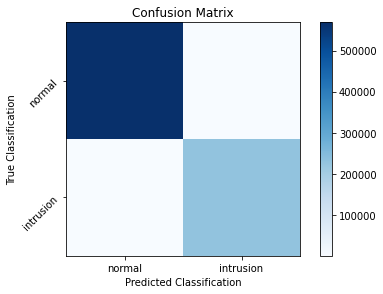

In [20]:
# compute confusion matrix
true_output = numpy.argmax(tf_output['test'].to_numpy(), axis=1)
cm = confusion_matrix(true_output, predicted)

# display confusion matrix values
display(pandas.DataFrame(cm, columns=tf_output['test'].columns, index=tf_output['test'].columns))
# display a confusion matrix visualization
pyplot.figure()
pyplot.imshow(cm, interpolation='nearest', cmap=pyplot.cm.Blues)
pyplot.title("Confusion Matrix")
pyplot.colorbar()
tick_marks = numpy.arange(len(tf_output['test'].columns))
pyplot.xticks(tick_marks, tf_output['test'].columns)
pyplot.yticks(tick_marks, tf_output['test'].columns, rotation=45)
pyplot.tight_layout()
pyplot.ylabel("True Classification")
pyplot.xlabel("Predicted Classification")
pyplot.show()

### Model Error Scoring

The performance of the model can also be measured through its precision, recall, and f1-scores. The general accuracy of the model is very positive, clocking in at over 99.9% accuracy. However, the accuracy is not truly representative when the different types of intrusions are considered - several intrusion types are underrepresented.

In [21]:
print(classification_report(true_output, predicted, digits=4, target_names=tf_output['test'].columns))

              precision    recall  f1-score   support

      normal     0.9997    0.9994    0.9995    569055
   intrusion     0.9984    0.9992    0.9988    231313

    accuracy                         0.9993    800368
   macro avg     0.9990    0.9993    0.9992    800368
weighted avg     0.9993    0.9993    0.9993    800368



<hr style="border-top: 2px solid #444">

## VI. Conclusion

The machine learning model's performance is far better than it might have initially expected to have been. The model's superb performance is attributed to the fact that the dataset is an artificial simulation with a clearly defined structure. This model's construction is that of a novice, and could even be further improved upon - the difference in performance seems that it would only be marginal though.
